### PoC of evaluation with parabola fitting
- マスク画像の作成時に二次曲線を用いた分類問題を扱った
- 放物線としてそれを利用し, 焦点または準線に用いられるpの値で評価が行えるか
- 簡単にまずは係数aについて考えるのもあり？

#### TODO
- get p
    - read mask img
    - detect boundary
    - parabola fitting
- summarize result
- visualize result


#### PROGRAM

- import library
    - matplotlib
    - numpy
    - pandas
    - python-opencv
    - scipy
    - tqdm

In [36]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm

- get p

In [37]:
# set params
U = [175, 200, 225, 250]
Q = [215, 304, 429]
D = [18, 24, 30]

# set dir
BINARY_DIR = '../data/binary/'
BOUNDARY_DIR = '../data/boundary/'


In [38]:
def detect_boundary(img, hei, wid, t=5):
    data = np.zeros((hei, 5))  # [index, start, end, flag, flag]

    # detection boundary
    for j in range(hei):
        data[j][0] = j  # index

        # detection from left side
        for i in range(wid - t):
            if np.all(img[j][i:i + t] == 255):
                data[j][1] = i
                data[j][3] = 1

                break

        # detection from right side
        if j > 700:
            for i in reversed(range(t, wid)):
                if np.all(img[j][i - t:i] == 255):
                    data[j][2] = i

                    if i > 1200:
                        data[j][4] = 0
                    else:
                        data[j][4] = 1

                    break

    return data


In [39]:
def model_func(x, *params):
    y = np.zeros_like(x)

    for i, param in enumerate(params):
        y += np.array(param * x ** i)

    return y

In [40]:
def fitting(data):
    a = np.zeros(1)
    b = np.zeros(1)

    for i in range(data.shape[0]):
        # left boundary
        if data[i, 3] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 1])

        # right boundary
        if data[i, 4] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 2])

    popt, pcov = curve_fit(model_func, b[1:], a[1:], p0=[1, 1, 1])

    return popt, pcov

In [41]:
bin_img = cv2.imread(BINARY_DIR + f'b_u_{175}_q_{215}_d_{18}_ppm_0.bmp', 0)

In [42]:
boundary = detect_boundary(img=bin_img, hei=1024, wid=1280)

In [43]:
popt, pcov = fitting(boundary)

In [44]:
length = 10
x1 = 505
y1 = 447
x2 = 506
y2 = 530

z = 10 / np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

x = np.linspace(0, 1280-1, 1280)
y = popt[0] + popt[1] * x + popt[2] * x ** 2

x *= z
y *= z

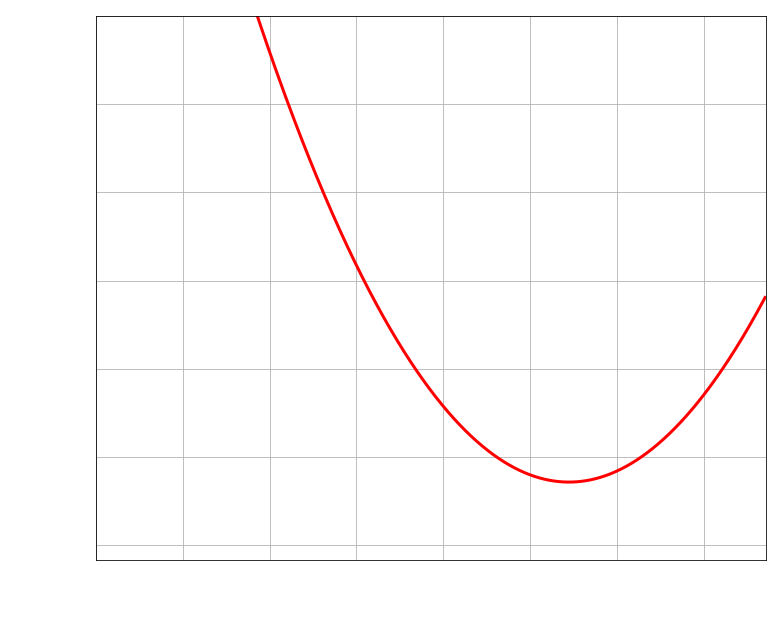

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.xlabel('$\it{x}$ [mm]', fontsize=28)
plt.ylabel('$\it{y}$ [mm]', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0, 1280*z)
plt.ylim(1024*z, 0)
plt.grid()

plt.plot(x, y, color='red', linewidth=3)
plt.show()

In [46]:
a_list = np.zeros(0)

# get a
for u in tqdm(U):
    for q in Q:
        for d in D:
            # read mask img
            bin_img = cv2.imread(BINARY_DIR + f'b_u_{u}_q_{q}_d_{d}_ppm_0.bmp', 0)

            # detect boundary
            boundary = detect_boundary(img=bin_img, hei=1024, wid=1280)

            # parabola fitting
            popt, pcov = fitting(boundary)

            a_list = np.append(a_list, popt[2] / z)


100%|██████████| 4/4 [01:16<00:00, 19.07s/it]


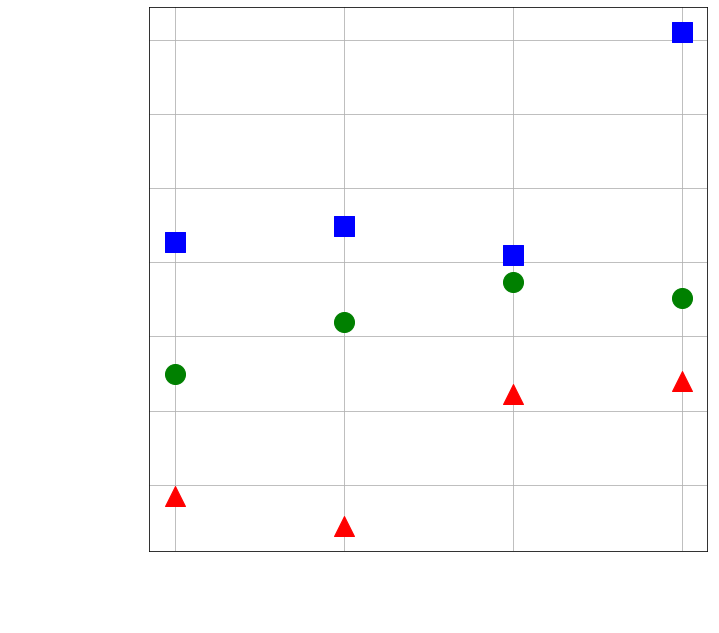

In [50]:
a_list *= -1

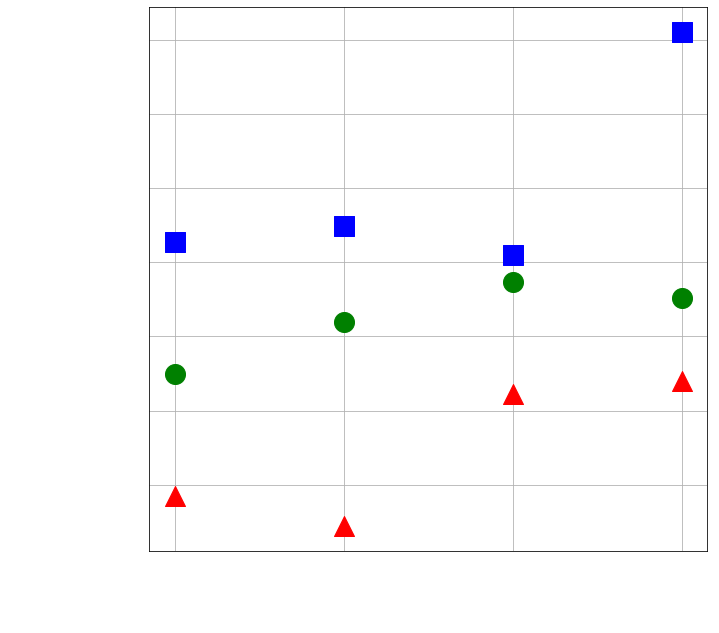

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.xlabel('$\it{U}$ [mm/s]', fontsize=32)
plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
plt.grid(zorder=9)

# q = 215
plt.scatter(175, a_list[0], s=400, marker=',', color='b', zorder=10)
plt.scatter(200, a_list[9], s=400, marker=',', color='b', zorder=10)
plt.scatter(225, a_list[18], s=400, marker=',', color='b', zorder=10)
plt.scatter(250, a_list[27], s=400, marker=',', color='b', zorder=10)

# q = 304
plt.scatter(175, a_list[3], s=400, marker='o', color='g', zorder=10)
plt.scatter(200, a_list[12], s=400, marker='o', color='g', zorder=10)
plt.scatter(225, a_list[21], s=400, marker='o', color='g', zorder=10)
plt.scatter(250, a_list[30], s=400, marker='o', color='g', zorder=10)

# q = 429
plt.scatter(175, a_list[6], s=400, marker='^', color='r', zorder=10)
plt.scatter(200, a_list[15], s=400, marker='^', color='r', zorder=10)
plt.scatter(225, a_list[24], s=400, marker='^', color='r', zorder=10)
plt.scatter(250, a_list[33], s=400, marker='^', color='r', zorder=10)

plt.show()

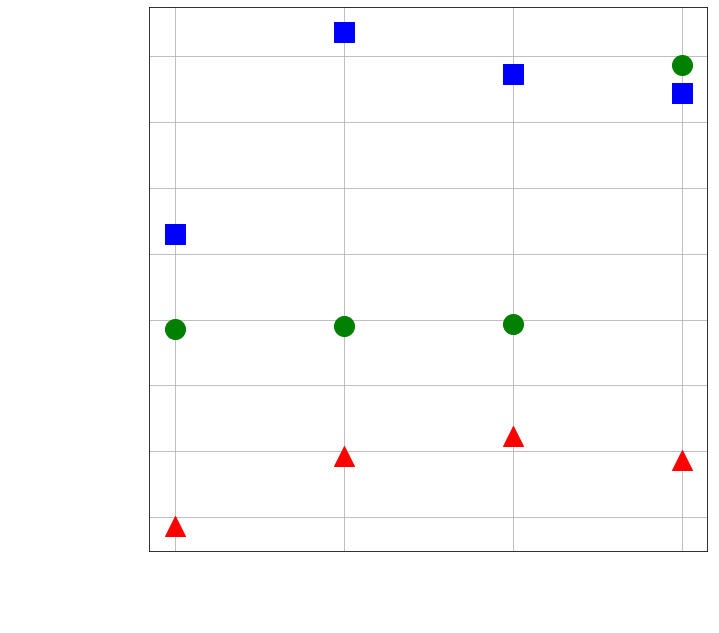

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.xlabel('$\it{U}$ [mm/s]', fontsize=32)
plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
plt.grid(zorder=9)

# q = 215
plt.scatter(175, a_list[1], s=400, marker=',', color='b', zorder=10)
plt.scatter(200, a_list[10], s=400, marker=',', color='b', zorder=10)
plt.scatter(225, a_list[19], s=400, marker=',', color='b', zorder=10)
plt.scatter(250, a_list[28], s=400, marker=',', color='b', zorder=10)

# q = 304
plt.scatter(175, a_list[4], s=400, marker='o', color='g', zorder=10)
plt.scatter(200, a_list[13], s=400, marker='o', color='g', zorder=10)
plt.scatter(225, a_list[22], s=400, marker='o', color='g', zorder=10)
plt.scatter(250, a_list[31], s=400, marker='o', color='g', zorder=10)

# q = 429
plt.scatter(175, a_list[7], s=400, marker='^', color='r', zorder=10)
plt.scatter(200, a_list[16], s=400, marker='^', color='r', zorder=10)
plt.scatter(225, a_list[25], s=400, marker='^', color='r', zorder=10)
plt.scatter(250, a_list[34], s=400, marker='^', color='r', zorder=10)

plt.show()

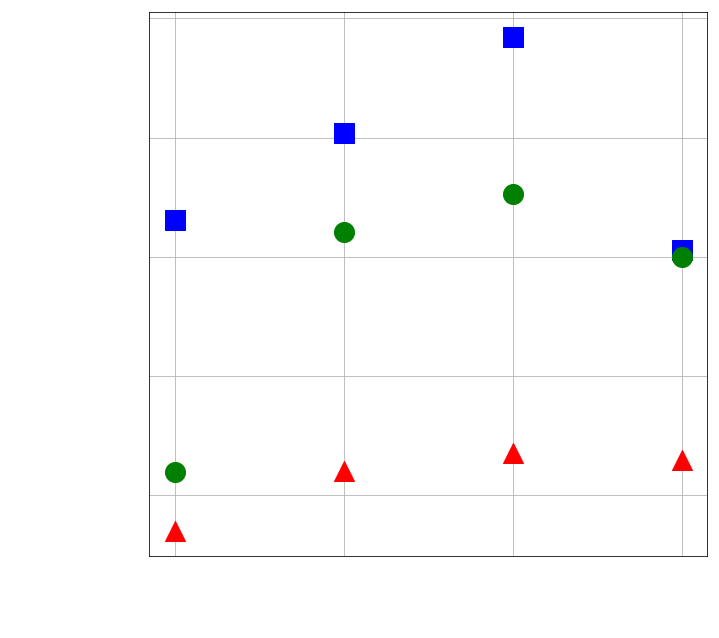

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.xlabel('$\it{U}$ [mm/s]', fontsize=32)
plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
plt.grid(zorder=9)

# q = 215
plt.scatter(175, a_list[2], s=400, marker=',', color='b', zorder=10)
plt.scatter(200, a_list[11], s=400, marker=',', color='b', zorder=10)
plt.scatter(225, a_list[20], s=400, marker=',', color='b', zorder=10)
plt.scatter(250, a_list[29], s=400, marker=',', color='b', zorder=10)

# q = 304
plt.scatter(175, a_list[5], s=400, marker='o', color='g', zorder=10)
plt.scatter(200, a_list[14], s=400, marker='o', color='g', zorder=10)
plt.scatter(225, a_list[23], s=400, marker='o', color='g', zorder=10)
plt.scatter(250, a_list[32], s=400, marker='o', color='g', zorder=10)

# q = 429
plt.scatter(175, a_list[8], s=400, marker='^', color='r', zorder=10)
plt.scatter(200, a_list[17], s=400, marker='^', color='r', zorder=10)
plt.scatter(225, a_list[26], s=400, marker='^', color='r', zorder=10)
plt.scatter(250, a_list[35], s=400, marker='^', color='r', zorder=10)

plt.show()

